In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math

# Multiresolution Hash encoding 2D

NeRF-ngp paper showed that hash encoding is allowing us to speed up conversion of nerf model.  
Here we will take apart multiresolution hash encoding and see how it works from inside, and implement our own encoding class.

## 2D Explanation

In [2]:
# Our dummy input represents one point in [near, far] bounding space
# dummy_input = torch.tensor([[-1., -2., 3]]) # 3D
dummy_input = torch.tensor([[-1., 3.], [2.0, -1.3], [1.0, -3.3]]) # 2D

# Normalizing our input by bounding distance
far=6
near=2
bound_distance = far - near

norm_dummy_input = (bound_distance - dummy_input) / (2 * bound_distance)

print('Input: \n',dummy_input)
print('Normalized Input: \n',norm_dummy_input)


Input: 
 tensor([[-1.0000,  3.0000],
        [ 2.0000, -1.3000],
        [ 1.0000, -3.3000]])
Normalized Input: 
 tensor([[0.6250, 0.1250],
        [0.2500, 0.6625],
        [0.3750, 0.9125]])


In [3]:
# Here we define parameters for our future enncoding

# Theoreticly we can encode as many dimentions as many primes we have
PRIMES = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

# Number of different resolution levels,
# each one will have finer grid 
n_levels = 5

# Maximum and minimum resulutions for levels
coarsest_resolution = 16
finest_resolution = 512 # from 512 to 524288

# Number of feature dimensions per one data point
# For 2D is 2; For 3D is 3; and so on... ???
n_dim_per_resolution = 2

# Max hash table size for each level 
max_entries_per_level = 2**14 # from 2^14 to 2^24


In [4]:
# First we compute resolutions for each level
# This is geometric progression between 
# coarsest_resolution and finest_resolution

resolutions = []

growth_factor = math.log(finest_resolution) - math.log(coarsest_resolution)
for level in range(1, n_levels+1):
    b_factor = math.floor(math.exp(growth_factor / (level)))
    level_resolution = coarsest_resolution * b_factor
    resolutions.append(level_resolution)

print("Resolutions:", resolutions)

Resolutions: [512, 80, 48, 32, 32]


In [5]:
def get_box_corners_2d(inputs, coarsest_resolution):
    # inputs = torch.tensor(inputs)
    box_index = torch.div(inputs, coarsest_resolution, rounding_mode='trunc') #inputs // coarsest_resolution
    # box_index = inputs // coarsest_resolution
    box_coordinates_low = box_index * coarsest_resolution
    box_coordinates_high = box_index * coarsest_resolution+coarsest_resolution

    low_x  = box_coordinates_low[:,0]
    high_x = box_coordinates_high[:,0]
    low_y  = box_coordinates_low[:,1]
    high_y = box_coordinates_high[:,1]

    c00 = torch.stack([low_x, low_y])
    c01 = torch.stack([low_x, high_y])
    c10 = torch.stack([high_x, high_y])
    c11 = torch.stack([high_x, low_y])

    coordinates = torch.stack([c00,c01,c10,c11])

    return coordinates.long()

_c = get_box_corners_2d(norm_dummy_input*512, coarsest_resolution)
print('Corners coordinates:\n',_c, '\n', _c.shape)


Corners coordinates:
 tensor([[[320, 128, 192],
         [ 64, 336, 464]],

        [[320, 128, 192],
         [ 80, 352, 480]],

        [[336, 144, 208],
         [ 80, 352, 480]],

        [[336, 144, 208],
         [ 64, 336, 464]]]) 
 torch.Size([4, 2, 3])


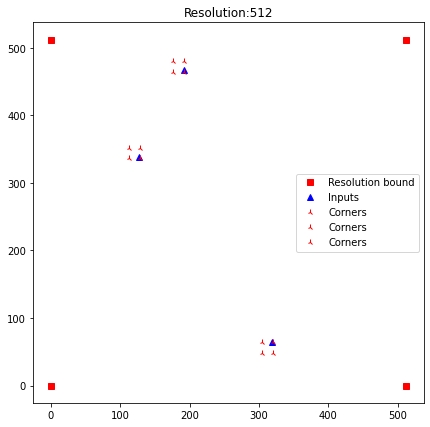

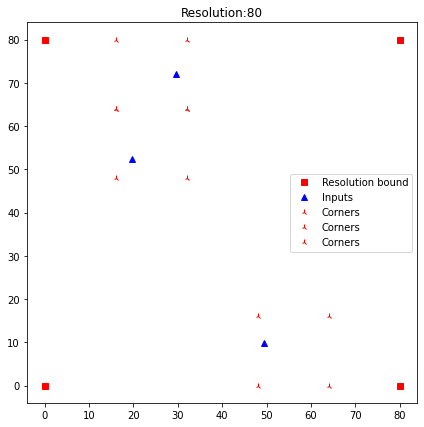

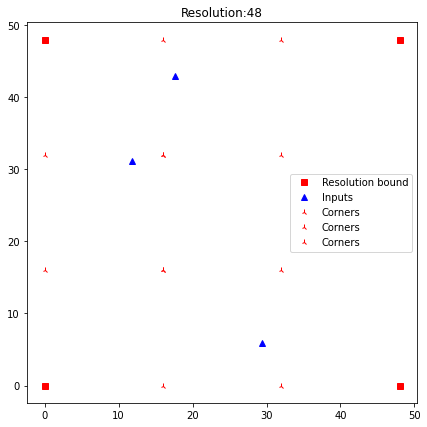

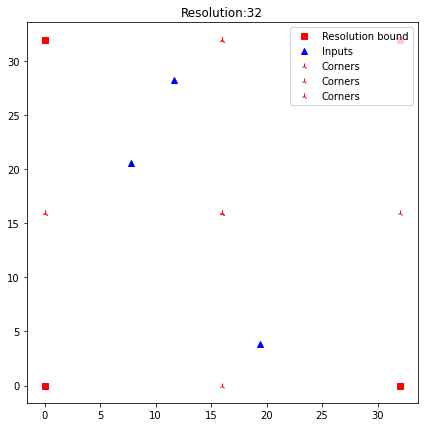

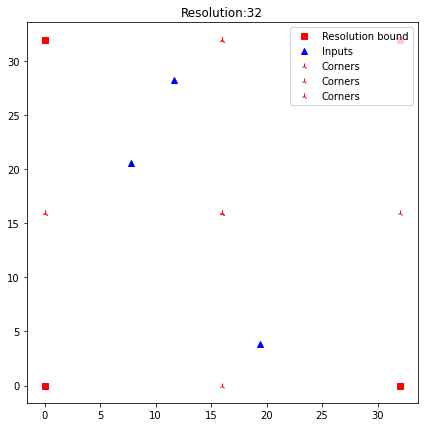

In [6]:
# Imagene we have a test 2D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

for resolution in resolutions:
    # LOGIC
    inputs = norm_dummy_input * (resolution-1)
    corners_coordinates = get_box_corners_2d(inputs, coarsest_resolution)
    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot([0,0,resolution,resolution], [0,resolution,0,resolution], 'rs',
    label='Resolution bound')

    # Input
    ax.plot(inputs[:,0], inputs[:,1], 'b^', label='Inputs')
    ax.plot(corners_coordinates[:,0], corners_coordinates[:,1], 'r2', label='Corners')

    plt.legend()
    plt.show()

In [7]:
# Making parametric hash table
# that will contain embeddings for each corner of hypercube
# Our text encoding will be just arange form 1 to table_size

hash_table = []
for resolution in resolutions:
    total_resolution = resolution ** n_dim_per_resolution
    
    table_size = int(min(total_resolution, max_entries_per_level))
    table = torch.zeros((table_size, n_dim_per_resolution))
    table = torch.arange(0,table.shape[0]+1).repeat(2,1).T
    table[:,1] += 1
    print("Hash table size: ",table.shape)
    # table = nn.Parameter(table)
    hash_table.append(table)

print('\nOne level of hash tables:\n',hash_table[0][:5].numpy())


Hash table size:  torch.Size([16385, 2])
Hash table size:  torch.Size([6401, 2])
Hash table size:  torch.Size([2305, 2])
Hash table size:  torch.Size([1025, 2])
Hash table size:  torch.Size([1025, 2])

One level of hash tables:
 [[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]]


In [8]:
# Finding corresponding feature in our hash table
# Imagene we at level 0 with resolution 512
level = 0
resolution = 512

# We substract -1 in order to fit input in a bounding box for corner cases
inputs = norm_dummy_input * (resolution-1)
# and get corners for current inputs
corners_coordinates = get_box_corners_2d(inputs, coarsest_resolution)
corners_coordinates.shape

torch.Size([4, 2, 3])

In [9]:
# Next is the sum for equesion 4 in original paper
# we multiply our coordinates on primes
# and mod divide my maaximum anound of entries per level
# and use XOR with previos computed hash index
hash_index = 0
for i in range(n_dim_per_resolution):
    hash_index = hash_index ^ (corners_coordinates[:, i] * PRIMES[i])
    print('HASH SUM: ',hash_index)
index = hash_index % max_entries_per_level
print('Final indexies:\n',index)


HASH SUM:  tensor([[304, 112, 176],
        [304, 112, 176],
        [320, 128, 192],
        [320, 128, 192]])
HASH SUM:  tensor([[ 127412916224,  891890415648, 1231658192992],
        [ 169883889008,  934361387792, 1274129165136],
        [ 169883888896,  934361388000, 1274129165088],
        [ 127412916336,  891890415824, 1231658192912]])
Final indexies:
 tensor([[ 4096, 14368,  4192],
        [11632,  4880, 11088],
        [11520,  5088, 11040],
        [ 4208, 14544,  4112]])


In [10]:
# We get hash table for current level
# index should be avalable in our level hash table
level_hash_table = hash_table[level]
assert level_hash_table.shape[0] >= index.max(), f'Index out of range for level {level}'
print(f'Hash level size for level {level}, is: ',level_hash_table.shape[0])

# Now we ready to extract features 
# from hash table for our corners
corners_features = level_hash_table[index]
corners_features.shape

Hash level size for level 0, is:  16385


torch.Size([4, 3, 2])

TODO: Explain bilinear intorpolation

In [11]:
def bilinear_interpolation_weights(x, y, x1, y1, x2, y2):
    # Ensure the points are within the defined rectangle
    if not torch.all(x1 <= x) and torch.all(x <= x2) and torch.all(y1 <= y) and torch.all(y <= y2):
        raise ValueError("The point (x, y) must be within the rectangle defined by (x1, y1) and (x2, y2)")

    # Calculate the distances
    dx1 = x - x1
    dx2 = x2 - x
    dy1 = y - y1
    dy2 = y2 - y

    # Calculate the area weights
    weight_11 = dx2 * dy2 / ((x2 - x1) * (y2 - y1))
    weight_21 = dx1 * dy2 / ((x2 - x1) * (y2 - y1))
    weight_12 = dx2 * dy1 / ((x2 - x1) * (y2 - y1))
    weight_22 = dx1 * dy1 / ((x2 - x1) * (y2 - y1))

    return weight_11, weight_21, weight_12, weight_22

# bilinear_interpolation_weights(0.375, 0.125, 0,0,1,1)

In [12]:
# Now we use bilinear intorpolation for 
# computing how much each feature conttribute 
# for description of our point

x1 = corners_coordinates[:,0][0]#[:2]
x2 = corners_coordinates[:,0][2]#[2:]
# print(corners_coordinates, '\n', x1, '\n', x2)

# y1 = torch.cat([corners_coordinates[:,1][:1], corners_coordinates[:,1][3:]])
# y2 = corners_coordinates[:,1][1:3]
y1 = corners_coordinates[:,1][0]
y2 = corners_coordinates[:,1][1]
# print(corners_coordinates, '\n',y1, '\n',y2)

x = inputs[:,0]
y = inputs[:,1]
# x,y

In [13]:
w1,w2,w3,w4 = bilinear_interpolation_weights(x,y,x1,y1,x2,y2)
print('Weights for different corners: ')
print('LB {:}\nRT {:}\nRB {:}\nLT {:}'.format(w1,w4,w3,w2))

Weights for different corners: 
LB tensor([0.0003, 0.0131, 0.0201])
RT tensor([0.9534, 0.1561, 0.1396])
RB tensor([0.0388, 0.0025, 0.0034])
LT tensor([0.0075, 0.8283, 0.8369])


In [14]:
# Make same size as our features
weights = torch.stack([w1,w2,w3,w4])
weights = torch.stack([weights for _ in range(n_dim_per_resolution)], -1)
# weights.shape == corners_features.shape
weights.shape, corners_features.shape

(torch.Size([4, 3, 2]), torch.Size([4, 3, 2]))

In [15]:
# Now we just multiply weights by features
weighted_features = corners_features * weights
weighted_features = weighted_features.sum(0)
weighted_features.shape

torch.Size([3, 2])

In [16]:
# lets just write wrapper for our interpolation function
# to simplify our code

def get_bilinear_weights(inputs, corners_coordinates, n_dim_per_resolution):
    x1 = corners_coordinates[:,0][0]#[:2]
    x2 = corners_coordinates[:,0][2]#[2:]

    y1 = corners_coordinates[:,1][0]
    y2 = corners_coordinates[:,1][1]

    x = inputs[:,0]
    y = inputs[:,1]

    w1,w2,w3,w4 = bilinear_interpolation_weights(x,y,x1,y1,x2,y2)

    # Make same size as our features
    weights = torch.stack([w1,w2,w3,w4])
    weights = torch.stack([weights for _ in range(n_dim_per_resolution)], -1)

    return weights


Then we just concat all the features for each level and we get our feature vector.  
Lets write whole loop...  

---

## Full 2D hashing loop

In [17]:
# Here we define parameters for our future enncoding

# Theoreticly we can encode as many dimentions as many primes we have
PRIMES = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

# Number of different resolution levels,
# each one will have finer grid 
n_levels = 5

# Maximum and minimum resulutions for levels
coarsest_resolution = 16
finest_resolution = 512 # from 512 to 524288

# Number of feature dimensions per one data point
# For 2D is 2; For 3D is 3; and so on... ???
n_dim_per_resolution = 2

# Max hash table size for each level 
max_entries_per_level = 2**14 # from 2^14 to 2^24


resolutions = []
growth_factor = math.log(finest_resolution) - math.log(coarsest_resolution)
for level in range(1, n_levels+1):
    b_factor = math.floor(math.exp(growth_factor / (level)))
    level_resolution = coarsest_resolution * b_factor
    resolutions.append(level_resolution)

hash_table = []
for resolution in resolutions:
    total_resolution = resolution ** n_dim_per_resolution
    
    table_size = int(min(total_resolution, max_entries_per_level))
    table = torch.zeros((table_size, n_dim_per_resolution))
    table = torch.arange(0,table.shape[0]+1).repeat(2,1).T
    table[:,1] += 1
    print("Hash table size: ",table.shape)
    # table = nn.Parameter(table)
    hash_table.append(table)




Hash table size:  torch.Size([16385, 2])
Hash table size:  torch.Size([6401, 2])
Hash table size:  torch.Size([2305, 2])
Hash table size:  torch.Size([1025, 2])
Hash table size:  torch.Size([1025, 2])


In [28]:
outputs = []
for level, resolution in enumerate(resolutions):
    # LOGIC
    inputs = norm_dummy_input * (resolution-1)
    corners_coordinates = get_box_corners_2d(inputs, coarsest_resolution)
    
    level_hash_table = hash_table[level]
    hash_index = 0
    for i in range(n_dim_per_resolution):
        hash_index = hash_index ^ (corners_coordinates[:, i] * PRIMES[i])
        # print('HASH SUM: ',hash_index)
    index = hash_index % level_hash_table.shape[0] #max_entries_per_level

    assert level_hash_table.shape[0] >= index.max(), f'Index out of range for level {level}'
    # print(f'Hash level size for level {level}, is: ',level_hash_table.shape[0])

    corners_features = level_hash_table[index]

    weights = get_bilinear_weights(inputs, corners_coordinates, n_dim_per_resolution)

    weighted_features = corners_features * weights
    weighted_features = weighted_features.sum(0)
    print(weighted_features.shape)
    outputs += [weighted_features]

torch.Size([3, 2])
torch.Size([3, 2])
torch.Size([3, 2])
torch.Size([3, 2])
torch.Size([3, 2])


In [32]:
features = torch.cat(outputs, -1)
features

tensor([[10598.1641, 10599.1641,  2638.4487,  2639.4487,   627.1777,   628.1777,
           304.6462,   305.6462,   304.6462,   305.6462],
        [11606.8936, 11607.8936,  1804.5868,  1805.5869,  1356.0879,  1357.0879,
           727.9876,   728.9875,   727.9876,   728.9875],
        [ 7055.0635,  7056.0635,  3474.0981,  3475.0981,  1290.1791,  1291.1790,
           745.0955,   746.0955,   745.0955,   746.0955]])

## Learning image with NN

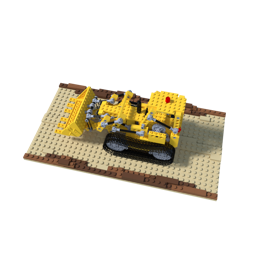

In [32]:
from PIL import Image

image = Image.open('./data/dnerf/lego/test/r_000.png').resize((256,256))
image

# MHE 3D

In [ ]:
def get_box_corners_3d(inputs, coarsest_resolution):
    box_index = inputs // coarsest_resolution
    c1 = box_index[0] * coarsest_resolution
    c2 = box_index[0] * coarsest_resolution+coarsest_resolution
    
    coordinates = [
        # Top square
        [c1[0], c1[1], c2[2]],
        [c2[0], c2[1], c2[2]],
        [c1[0], c2[1], c2[2]],
        [c2[0], c1[1], c2[2]],
        # Bottom square
        [c1[0], c1[1], c1[2]],
        [c2[0], c2[1], c1[2]],
        [c1[0], c2[1], c1[2]],
        [c2[0], c1[1], c1[2]],
    ]
    return np.array(coordinates).astype(int)



In [ ]:
# Imagene we have a test 3D input
# we go through every resolution we have
# and finding corner coordinated of a box that surraunds input.
# See get_box_corners_2d() 

test_input = torch.tensor([[0.1,0.2, 1.0]])

for resolution in resolutions:
    # LOGIC
    inputs = test_input * (resolution-1)
    
    
    c = get_box_corners_3d(inputs, coarsest_resolution)

    # PLOTTING
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Resolution:'+str(resolution))

    # Plot resolution box
    ax.plot(
        [0,0,0,0,resolution,resolution,resolution,resolution], 
        [0,resolution,0,resolution,0,resolution,0,resolution],
        [0,0,resolution,resolution,0,0,resolution,resolution],
        'r.',
        label='Resolution bound')

    # Input
    ax.plot(
        inputs[0,0], 
        inputs[0,1],
        inputs[0,2],
        'b^', 
        label='Inputs')
    print(inputs, c)
    ax.plot(c[0,0], c[0,1], c[0,2], 'r1', label='X1top')
    ax.plot(c[1,0], c[1,1], c[1,2], 'r1', label='X2top')
    ax.plot(c[2,0], c[2,1], c[2,2], 'r1', label='X3top')
    ax.plot(c[3,0], c[3,1], c[3,2], 'r1', label='X4top')

    ax.plot(c[4,0], c[4,1], c[4,2], 'r2', label='X1bot')
    ax.plot(c[5,0], c[5,1], c[5,2], 'r2', label='X2bot')
    ax.plot(c[6,0], c[6,1], c[6,2], 'r2', label='X3bot')
    ax.plot(c[7,0], c[7,1], c[7,2], 'r2', label='X4bot')

    plt.legend()
    plt.show()
    